In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [13]:

games_df = pd.read_csv('../Datasets/secondsportsdataset.csv')


In [14]:
team_abbreviations = ['CHI','BRK', 'MIA', 'MIL', 'PHI', 'CLE', 'CHO', 'TOR', 'WAS', 'BOS', 'NYK', 'ATL', 'IND', 'DET', 'ORL',
                      'PHO', 'GSW', 'UTA', 'MEM', 'DAL', 'DEN', 'LAL', 'LAC', 'MIN', 'POR', 'SAS', 'SAC', 'NOP', 'OKC', 'HOU']


#NO -> NOP
#BKN -> BRK
#SA -> SAS
#NY -> NYK
#CHA -> CHO
#GS -> GSW


#We need mappings for differences in the data
mappings = {
    'NO': 'NOP',
    'BKN': 'BRK',
    'SA': 'SAS',
    'NY': 'NYK',
    'CHA': 'CHO',
    'GS': 'GSW'
}

over_under_lines_dfs = []
for team in team_abbreviations:
    team_line_df = pd.read_csv('../Datasets/OU_Lines_Data/' + str(team) + '.csv')
    team_line_df[['HomeTeam', 'AwayTeam']] = team_line_df[['HomeTeam', 'AwayTeam']].replace(mappings)
    over_under_lines_dfs.append(team_line_df)

Total_OU_lines = pd.concat(over_under_lines_dfs, axis=0, ignore_index=True)

Total_OU_lines.shape

# Convert the date column to datetime objects
Total_OU_lines['DayString'] = pd.to_datetime(Total_OU_lines['DayString'], format='%m/%d/%y')

# Optional: Format the date in your desired output format
Total_OU_lines['DayString'] = Total_OU_lines['DayString'].dt.strftime('%Y-%m-%d')

#Only keep relevant columns
OU_lines = Total_OU_lines[['DayString', 'HomeTeam', 'AwayTeam', 'ConsensusOverUnder']].drop_duplicates()

In [15]:
games_df['Home_Team'] = np.where(games_df['location'] == 'Home', games_df['Team_Name'], games_df['opponent_abbr'])
games_df['Away_Team'] = np.where(games_df['location'] == 'Away', games_df['Team_Name'], games_df['opponent_abbr'])
games_df['Home_Points'] = np.where(games_df['location'] == 'Home', games_df['points_scored'], games_df['points_allowed'])
games_df['Away_Points'] = np.where(games_df['location'] == 'Away', games_df['points_scored'], games_df['points_allowed'])

games_encoded = pd.get_dummies(games_df, columns=['Home_Team','Away_Team',])

#Add back original categorical variable. 

games_encoded = pd.concat([games_df[['Home_Team', 'Away_Team']], games_encoded], axis=1)

games_encoded = games_encoded.sort_values(by='datetime')

games_encoded['Total_Score'] = games_encoded['Home_Points'] + games_encoded['Away_Points']


#We want to connect the Total_OU_lines to the games being played. 

games_encoded = pd.merge(games_encoded, OU_lines, 
                     left_on=['datetime', 'Home_Team', 'Away_Team'], 
                     right_on=['DayString', 'HomeTeam', 'AwayTeam'],
                     how='left')

games_encoded = games_encoded.drop(columns=['DayString', 'HomeTeam', 'AwayTeam'])


In [16]:
OU_lines[OU_lines['HomeTeam'] == 'HOU'].sort_values(by='DayString')

,DayString,HomeTeam,AwayTeam,ConsensusOverUnder
519,2023-10-29,HOU,GSW,223.5
222,2023-11-01,HOU,CHO,222.5
836,2023-11-04,HOU,SAC,221.0
835,2023-11-06,HOU,SAC,218.0
679,2023-11-08,HOU,LAL,224.0
865,2023-11-10,HOU,NOP,220.0
644,2023-11-12,HOU,DEN,216.5
573,2023-11-22,HOU,MEM,212.5
638,2023-11-24,HOU,DEN,215.5
885,2023-12-06,HOU,OKC,225.0


In [17]:
games_encoded[games_encoded['Home_Team']== 'HOU']

,Home_Team,Away_Team,Unnamed: 0,boxscore_index,date,datetime,game,location,losses,opponent_abbr,...,Away_Team_PHI,Away_Team_PHO,Away_Team_POR,Away_Team_SAC,Away_Team_SAS,Away_Team_TOR,Away_Team_UTA,Away_Team_WAS,Total_Score,ConsensusOverUnder
73,HOU,GSW,202310290HOU,202310290HOU,"Sun, Oct 29, 2023",2023-10-29,3,Away,1.0,HOU,...,0,0,0,0,0,0,0,0,201.0,223.5
78,HOU,GSW,202310290HOU,202310290HOU,"Sun, Oct 29, 2023",2023-10-29,3,Home,3.0,GSW,...,0,0,0,0,0,0,0,0,201.0,223.5
120,HOU,CHO,202311010HOU,202311010HOU,"Wed, Nov 1, 2023",2023-11-01,4,Home,3.0,CHO,...,0,0,0,0,0,0,0,0,247.0,222.5
132,HOU,CHO,202311010HOU,202311010HOU,"Wed, Nov 1, 2023",2023-11-01,4,Away,3.0,HOU,...,0,0,0,0,0,0,0,0,247.0,222.5
168,HOU,SAC,202311040HOU,202311040HOU,"Sat, Nov 4, 2023",2023-11-04,5,Home,3.0,SAC,...,0,0,0,1,0,0,0,0,196.0,221.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,HOU,GSW,202404040HOU,202404040HOU,"Thu, Apr 4, 2024",2024-04-04,76,Home,NaN,GSW,...,0,0,0,0,0,0,0,0,NaN,NaN
2290,HOU,MIA,202404050HOU,202404050HOU,"Fri, Apr 5, 2024",2024-04-05,77,Away,NaN,HOU,...,0,0,0,0,0,0,0,0,NaN,NaN
2303,HOU,MIA,202404050HOU,202404050HOU,"Fri, Apr 5, 2024",2024-04-05,77,Home,NaN,MIA,...,0,0,0,0,0,0,0,0,NaN,NaN
2350,HOU,ORL,202404090HOU,202404090HOU,"Tue, Apr 9, 2024",2024-04-09,79,Away,NaN,HOU,...,0,0,0,0,0,0,0,0,NaN,NaN


In [18]:
# Function to calculate cumulative average excluding the current row
def cumulative_average(series):
    return series.expanding().mean().shift(2)

def rolling_average(series, window_size):
    # Calculate the rolling average with the specified window size
    # 'min_periods=1' ensures that we get an average even if there are fewer data points than the window size
    return series.rolling(window=window_size, min_periods=1).mean().shift(2)


team_view = games_encoded[['date', 'Team_Name','points_scored', 'points_allowed']].sort_values(by='date')

team_view = team_view.drop_duplicates(subset=['date', 'Team_Name'])

team_view['avg_points_scored'] = team_view.groupby('Team_Name')['points_scored'].apply(cumulative_average)
team_view['avg_points_allowed'] = team_view.groupby('Team_Name')['points_allowed'].apply(cumulative_average)


# Merge average points scored for home and away teams
games_encoded = games_encoded.merge(team_view[['date', 'Team_Name', 'avg_points_scored']], left_on=['date', 'Home_Team'], right_on=['date', 'Team_Name'], how='left', suffixes=('', '_home'))
games_encoded = games_encoded.merge(team_view[['date', 'Team_Name', 'avg_points_scored']], left_on=['date', 'Away_Team'], right_on=['date', 'Team_Name'], how='left', suffixes=('_home', '_away'))


# Merge average points allowed for home and away teams
games_encoded = games_encoded.merge(team_view[['date', 'Team_Name', 'avg_points_allowed']], left_on=['date', 'Home_Team'], right_on=['date', 'Team_Name'], how='left', suffixes=('', '_home'))
games_encoded = games_encoded.merge(team_view[['date', 'Team_Name', 'avg_points_allowed']], left_on=['date', 'Away_Team'], right_on=['date', 'Team_Name'], how='left', suffixes=('_home', '_away'))


#Now, we also want cumulative average values for just when the specific team is playing their home/away side.

# Calculate cumulative average points scored at home for each team
games_encoded['home_team_home_points_avg'] = games_encoded.groupby('Home_Team')['Home_Points'].apply(cumulative_average)
games_encoded['home_team_home_concede_avg'] = games_encoded.groupby('Home_Team')['Away_Points'].apply(cumulative_average)

# Calculate cumulative average points scored away for each team
games_encoded['away_team_away_points_avg'] = games_encoded.groupby('Away_Team')['Away_Points'].apply(cumulative_average)
games_encoded['away_team_away_concede_avg'] = games_encoded.groupby('Away_Team')['Home_Points'].apply(cumulative_average)

houston_games = games_encoded.loc[games_encoded['Home_Team'] == 'HOU']

# Define window sizes
windows = [1, 3, 7]

for window in windows:
    # Rolling average points scored at home
    home_score= f'rolling_{window}_home_points_score'
    home_concede = f'rolling_{window}_home_points_concede'
    games_encoded[home_score] = games_encoded.groupby('Home_Team')['Home_Points'].apply(lambda x: rolling_average(x, window*2))
    #games_encoded[home_concede] = games_encoded.groupby('Home_Team')['Away_Points'].apply(lambda x: rolling_average(x, window*2))


    # Rolling average points scored away
    away_score= f'rolling_{window}_away_points_score'
    away_concede = f'rolling_{window}_away_points_concede'
    games_encoded[away_score] = games_encoded.groupby('Away_Team')['Away_Points'].apply(lambda x: rolling_average(x, window*2))
    games_encoded[away_concede] = games_encoded.groupby('Away_Team')['Home_Points'].apply(lambda x: rolling_average(x, window*2))


In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# Original Data
timeframe_slice = games_encoded.loc[(games_encoded['datetime'] > '2023-11-01') & (games_encoded['datetime'] <= '2023-12-30')]

# Copy the necessary columns for later reference BEFORE dropping NA
reference_data = timeframe_slice[['datetime', 'game', 'Home_Team', 'Away_Team', 'Total_Score','ConsensusOverUnder']].copy()

# Prepare the experiment data
columns_to_drop = ['Home_Points', 'Away_Points', 'Home_Team', 'Away_Team', 'Unnamed: 0', 'boxscore_index', 'date',
                   'datetime', 'game', 'location', 'losses', 'opponent_abbr',
                   'opponent_name', 'playoffs', 'points_allowed', 'points_scored',
                   'result', 'streak', 'time', 'wins', 'Team_Name_home', 'Team_Name_away', 'ConsensusOverUnder']
experiment_data = timeframe_slice.drop(columns=columns_to_drop)

# Drop NA from both experiment_data and reference_data
experiment_data = experiment_data.dropna()
reference_data = reference_data.loc[experiment_data.index]

X = experiment_data.drop(columns=['Total_Score'])
y = experiment_data['Total_Score']

# Calculate the split index
split_index = int(len(X) * 0.8)

# Split the data
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

# Train the model
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(X_train, y_train)

# Make predictions
predictions = regr.predict(X_test)

# Align predictions with the original data
predictions_df = pd.DataFrame(predictions, index=X_test.index, columns=['Predictions'])
aligned_predictions = reference_data.join(predictions_df, how='inner')



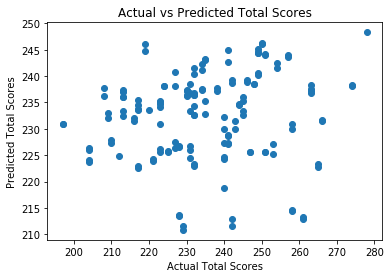

Mean Absolute Error: 14.425309406839832


In [20]:
#Prediction Metrics

import matplotlib.pyplot as plt

plt.scatter(y_test, predictions)
plt.xlabel("Actual Total Scores")
plt.ylabel("Predicted Total Scores")
plt.title("Actual vs Predicted Total Scores")
plt.show()

mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error:", mae)

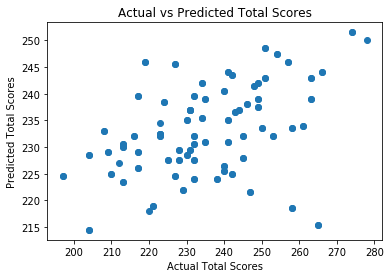

Mean Absolute Error: 12.22635135135135


In [21]:
#Prediction Metrics for SPORTSBOOK

import matplotlib.pyplot as plt

predictions = aligned_predictions['ConsensusOverUnder']

plt.scatter(y_test, predictions)
plt.xlabel("Actual Total Scores")
plt.ylabel("Predicted Total Scores")
plt.title("Actual vs Predicted Total Scores")
plt.show()

mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error:", mae)

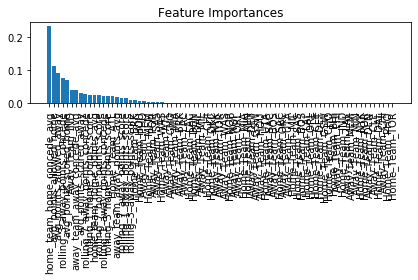

Index(['home_team_home_concede_avg', 'avg_points_allowed_home',
       'avg_points_allowed_away', 'rolling_3_away_points_concede',
       'avg_points_scored_home'],
      dtype='object')


In [22]:
importances = regr.feature_importances_

import matplotlib.pyplot as plt

# Sort the feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]
feature_names = X_train.columns
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), feature_names[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()


print(feature_names[sorted_indices][:5])

In [23]:
aligned_predictions = aligned_predictions[aligned_predictions['datetime'] <= '2023-12-29']

aligned_predictions['Difference'] = aligned_predictions['Predictions'] - aligned_predictions['ConsensusOverUnder']

aligned_predictions['Bet'] = np.where(aligned_predictions['Difference'] > 0, 1, -1)

aligned_predictions['Outcome'] = np.where(((aligned_predictions['Total_Score'] - aligned_predictions['ConsensusOverUnder'])
                                          * aligned_predictions['Bet']) > 0, 1, -1)

print('Sum of Units ' + str(np.sum(aligned_predictions['Outcome'])))

print('Win Percentage = ' + str(np.sum(aligned_predictions['Outcome'] > 0) / len(aligned_predictions['Outcome'])))



Sum of Units -10
Win Percentage = 0.46621621621621623


In [83]:
aligned_predictions.loc[aligned_predictions['datetime'] == '2023-12-26']

np.mean(np.abs(aligned_predictions['Predictions'] - aligned_predictions['Total_Score'])) #Our average is 14.6 off

np.mean(np.abs(aligned_predictions['ConsensusOverUnder'] - aligned_predictions['Total_Score'])) #Their average is 12.22 off

12.22635135135135

In [24]:
np.mean(np.abs(games_encoded['ConsensusOverUnder'] - games_encoded['Total_Score'])) #Average in total dataset is 13.589 off. 



13.58974358974359

In [25]:
today_date = '2023-12-31'

today_test = games_encoded.loc[games_encoded['datetime'] == today_date]

reference_data = today_test[['datetime', 'game', 'Home_Team', 'Away_Team', 'ConsensusOverUnder']].copy()

# Prepare the experiment data
today_train = today_test.drop(columns=columns_to_drop)

today_train = today_train.drop(columns=['Total_Score']).dropna()

reference_data = reference_data.loc[today_train.index]

today_predictions = regr.predict(today_train)

pred_df = pd.DataFrame(today_predictions, index=today_train.index, columns=['Predictions'])

aligned_today = reference_data.join(pred_df, how='inner')

aligned_today

,datetime,game,Home_Team,Away_Team,ConsensusOverUnder,Predictions
948,2023-12-31,32,PHO,ORL,NaN,234.130940
949,2023-12-31,33,OKC,BRK,NaN,245.678371
950,2023-12-31,31,MEM,SAC,NaN,223.641864
951,2023-12-31,32,SAS,BOS,NaN,239.021519
952,2023-12-31,31,OKC,BRK,NaN,245.541430
953,2023-12-31,33,NOP,LAL,NaN,226.615990
954,2023-12-31,32,PHO,ORL,NaN,234.730242
956,2023-12-31,32,MEM,SAC,NaN,223.866965
957,2023-12-31,32,SAS,BOS,NaN,239.344543
958,2023-12-31,32,WAS,ATL,NaN,244.108773
